# Schrödinger Bridge Scheme for Minimizing Entropy

**Author**: Medha Agarwal

**Last modified**: April 02, 2024

In this notebook, we look at the performance of two different methods for estimating discrete Schrödinger bridge. Further, we look at the SB scheme for minimizing the entropy functional and compare it to the continuous time gradient flow.

In [1]:
import numpy as np
import os
from scipy.special import expit
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle as pkl
from estimate_SB import _gibbs_one_iter, schbridge, sinkhorn, cost_matrix
from matplotlib.animation import FuncAnimation
import seaborn as sns
import time

In [23]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams["axes.labelsize"] = 15
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['text.usetex'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

sns.set_style("white")

In [3]:
def cost_matrix(X, Y):
    """L2 cost matrix
    """
    n = X.shape[0]
    return (X.reshape((n,1)) - X.reshape((1,n)))**2

Suppose I have $(x_1, \dots, x_n)$ observed from $\rho_0$ to start with. I want to conduct an SB scheme on these samples for minimizing 
$$\mathcal{F} = \frac{1}{2} Ent(\rho).$$

Recall that the SB scheme with the starting measure $\rho$ is
$$\rho_\epsilon^* = (Id + \nabla f_{\epsilon, \rho})_\# \rho$$
Now the SB scheme is 
$$x_i \mapsto x_i + \nabla f_{\epsilon, \rho_n}(x_i)$$
We know that $E_{\pi_{\epsilon, \rho_n}}[Y | X = x_i] = x_i - \nabla f_{\epsilon, \rho_n}(x_i)$. Therefore, we want to calculate the barycentric projection using an approximation of $\pi_{\epsilon, \rho_n}$. 

Let this be $\hat{\pi}_{\epsilon, \rho_n}$ calculated using method above using Sinkhorn or Gibbs sampling. Then we have that $\hat{\pi}_{\epsilon, \rho_n} \in [0,1]^{n \times n}$ is matrix. And note that
\begin{align*}
\nabla \hat{f}_{\epsilon, \rho_n}(x_i) &= x_i - E_{\hat{\pi}_{\epsilon, \rho_n}}[Y|X=x_i]\\
&= x_i - \frac{\sum_{j=1}^n x_j \hat{\pi}_{\epsilon, \rho_n}^{ij}}{\rho_n(x_i)}\\
&= x_i - n\sum_{j=1}^n x_j \hat{\pi}_{\epsilon, \rho_n}^{ij}\\
\end{align*}

Finally, we have the estimated SB scheme as
$$x_i \mapsto 2x_i- n\sum_{j=1}^n x_j \hat{\pi}_{\epsilon, \rho_n}^{ij}$$

We use two different methods to estimate the Schrödinger bridge. The first one uses the celebrated Sinkhorn iterations and the second uses the MCMC method from Harchaoui (2020).


#### MCMC method for estimationg Schrödinger bridge

In [7]:
n_list = 200*np.arange(1, 6)
gibbs_plan_list, cost_list, accept_ratio_list = [], [], []
eps = 0.01
mu, sigma_squared, sigma = 0, 1, 1
X_ = np.random.normal(mu, sigma, n_list[-1])
cost_mat = cost_matrix(X_, X_)

Let us look at how using numba helps with saving compilation time.

In [8]:
start = time.perf_counter()
gibbs_cost, gibbs_plan, costs, accept = schbridge(cost_mat, eps=eps, total=10000, discard=0)
end = time.perf_counter()
print("Elapsed (with compilation) for {} samples = {}s".format(costs.shape[0], (end - start)))

Elapsed (with compilation) for 10000 samples = 3.4600636889226735s


In [9]:
start = time.perf_counter()
gibbs_cost, gibbs_plan, costs, accept = schbridge(cost_mat, eps=eps, total=1000, discard=0)
end = time.perf_counter()
print("Elapsed (after compilation) for {} samples = {}s".format(costs.shape[0], (end - start)))

Elapsed (after compilation) for 1000 samples = 0.35850050626322627s


Now we compare the SB estimation with increasing number samples. 

In [10]:
## THIS CODE TAKES >12 MINUTES TO RUN

for i in tqdm(range(len(n_list))):
    n = n_list[i]
    X = X_[:n]
    cost_mat = cost_matrix(X, X)
    gibbs_cost, gibbs_plan, all_costs, accept = schbridge(cost_mat, eps=eps, total=1000000, discard=10000)
    cumsum = np.cumsum(all_costs)
    cumavg = cumsum / np.arange(1, len(all_costs) + 1)
    gibbs_plan_list.append(gibbs_plan)
    cost_list.append(cumavg)
    accept_ratio_list.append(accept)

100%|██████████| 5/5 [12:23<00:00, 148.76s/it]


In [12]:
with open(f"mcmc/sample_size_increments/cost_list_eps{eps}.pkl", "wb") as input_file:
    pkl.dump(cost_list, input_file)
    
with open(f"mcmc/sample_size_increments/accept_ratio_list_eps{eps}.pkl", "wb") as input_file:
    pkl.dump(accept_ratio_list, input_file)
    
with open(f"mcmc/sample_size_increments/gibbs_plan_list_eps{eps}.pkl", "wb") as input_file:
    pkl.dump(gibbs_plan_list, input_file)


In [103]:

with open(f"mcmc/sample_size_increments/cost_list_eps{eps}.pkl", "rb") as input_file:
    cost_list = pkl.load(input_file)
    
with open(f"mcmc/sample_size_increments/accept_ratio_list_eps{eps}.pkl", "rb") as input_file:
    accept_ratio_list = pkl.load(input_file)
    
with open(f"mcmc/sample_size_increments/gibbs_plan_list_eps{eps}.pkl", "rb") as input_file:
    gibbs_plan_list = pkl.load(input_file)


FileNotFoundError: [Errno 2] No such file or directory: 'mcmc/sample_size_increments/cost_list_eps0.001.pkl'

[]

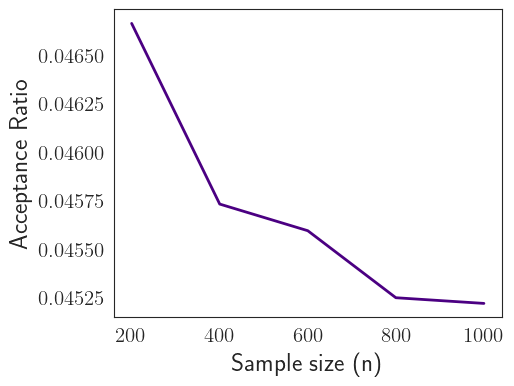

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(n_list, accept_ratio_list, color='indigo', linewidth=2)
plt.xlabel('Sample size (n)')
plt.ylabel('Acceptance Ratio')
plt.plot()

/tmp/ipykernel_2859477/2735872146.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


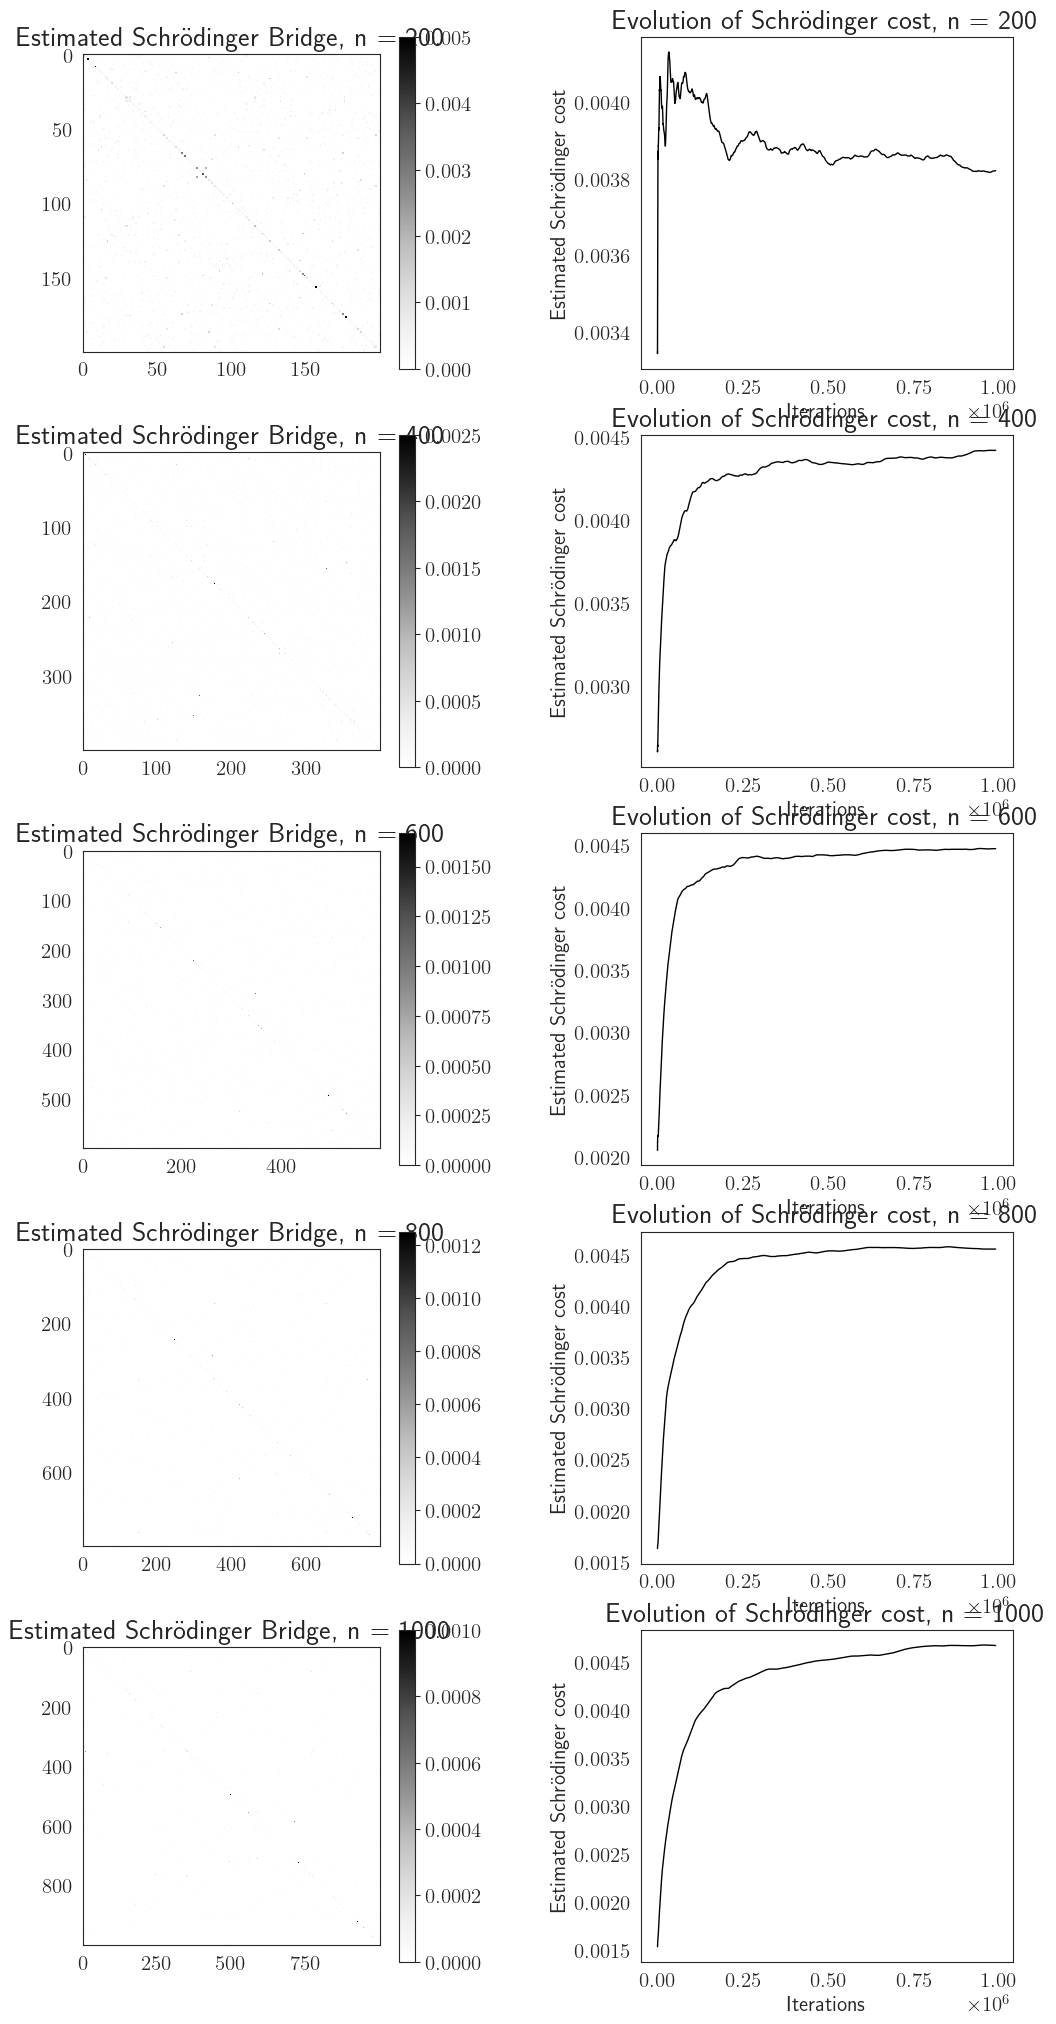

In [105]:
fig, axs = plt.subplots(len(n_list), 2, figsize=(12,5*len(n_list)), gridspec_kw={'wspace': .5})

for i in range(len(n_list)):
    axs[i,0].imshow(gibbs_plan_list[i], cmap='Greys', interpolation='nearest')
    axs[i,0].figure.colorbar(axs[i,0].images[0], ax=axs[i,0])
    axs[i,0].set_title(f"Estimated Schrödinger Bridge, n = {n_list[i]}")
    axs[i,1].plot(np.arange(len(cost_list[i]))+1, cost_list[i], color='black')
    axs[i,1].set_xlabel('Iterations')
    axs[i,1].set_ylabel('Estimated Schrödinger cost')
    axs[i,1].set_title(f"Evolution of Schrödinger cost, n = {n_list[i]}")

plt.tight_layout()
plt.show()

In [24]:
# Create Particles for forward process
n = 500
eps = 0.001
mu, sigma_squared, sigma = 0, 4, 2
X = np.random.normal(mu, sigma, n)
cost_mat = cost_matrix(X, X)

In [26]:
# using MCMC for estimating Schrödinger bridge
start = time.perf_counter()
gibbs_cost, gibbs_plan, costs, accept = schbridge(cost_mat, eps=eps, total=1e6, discard=1e4)
end = time.perf_counter()
print("Gibbs time = {}s".format((end - start)))

# using Sinkhorn for estimating Schrödinger bridge
start = time.perf_counter()
sink_cost, sink_plan = sinkhorn(cost_mat, np.ones(n)/n, np.ones(n)/n, eps, precision=1e-8, maxiter=1e4)
end = time.perf_counter()
print("Sinkhorn time = {}s".format((end - start)))

Gibbs time = 91.24059045733884s
Sinkhorn time = 176.86623731488362s


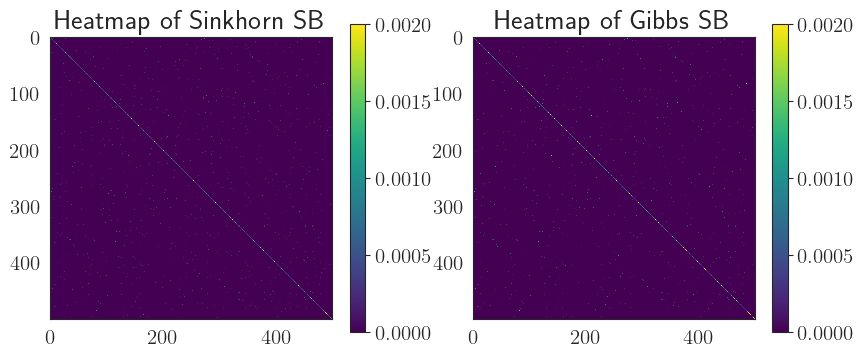

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
# Create a heatmap
axs[0].imshow(sink_plan, cmap='viridis', interpolation='nearest')
axs[1].imshow(gibbs_plan, cmap='viridis', interpolation='nearest')
for ax in axs:
    ax.figure.colorbar(ax.images[0], ax=ax)

# Show the plot
axs[0].set_title('Heatmap of Sinkhorn SB')
axs[1].set_title('Heatmap of Gibbs SB')
plt.show()

In [73]:
# functions for making plots and calculating deterministic variances

def draw_gaussian(mean, std_dev):
    # Generate data points for the x-axis
    x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 1000)

    # Compute the probability density function (PDF) for each data point
    pdf_values = norm.pdf(x, mean, std_dev)

    return x, pdf_values

def forward_SB_var(sigma_squared, eps, k=1):

    new_sigma_squared = ((2 - (sigma_squared/(np.sqrt((sigma_squared**2) + (eps**2)/4) + eps/2)))**2)*sigma_squared

    if k==1:
        return new_sigma_squared
    elif k==0:
        return sigma_squared
    else:
        return forward_SB_var(new_sigma_squared, eps, k=k-1)

def reverse_SB_var(sigma_squared, eps, k=1):

    new_sigma_squared = ((sigma_squared/(np.sqrt((sigma_squared**2) + (eps**2)/4) + eps/2))**2)*sigma_squared

    if k==1:
        return new_sigma_squared
    elif k==0:
        return sigma_squared
    else:
        return reverse_SB_var(new_sigma_squared, eps, k=k-1)

def draw_gaussian_mix(mu1=-2, mu2=2, std_dev=1):
    # Generate data points for the x-axis

    x = np.linspace(mu1 - 3*std_dev, mu2 + 3*std_dev, 1000)
    # Compute the probability density function (PDF) for each data point
    pdf_values = 0.5*norm.pdf(x, mu1, std_dev) + 0.5*norm.pdf(x, mu2, std_dev)

    return x, pdf_values


In [125]:
def update_plot(frame, SB_steps, steps, eps, sigma_squared, forward, xlim, ylim):
    cmap = plt.get_cmap("gist_heat")
    color = cmap((frame)/len(steps))

    plt.clf()  # Clear the previous plot (if any)
    
    # Your plotting logic for each frame
    step = steps[frame]
    plt.hist(SB_steps[frame], density=True, alpha=0.6, bins=30, color=color, edgecolor='white')
    plt.title(f'Time: {np.round(eps*step, 1)}')
    plt.xlim(-xlim, xlim)
    plt.ylim(0, ylim)

    if forward:
        true_var = sigma_squared + step*eps
        SB_var = forward_SB_var(sigma_squared, eps, k=step)
    else:
        true_var = sigma_squared - step*eps
        SB_var = reverse_SB_var(sigma_squared, eps, k=step)

    x, pdf_values = draw_gaussian(mean=0, std_dev=np.sqrt(true_var))
    plt.plot(x, pdf_values, label=r'$\rho_t$', color='orange', linewidth=3)
    x, pdf_values = draw_gaussian(mean=0, std_dev=np.sqrt(SB_var))
    plt.plot(x, pdf_values, label=r'$\hat \rho_t$', color='green')
    plt.legend()

In [ ]:
def update_plot_gauss_mix(frame, SB_steps, steps, eps, mu1, mu2, sigma_squared, forward, xlim, ylim):

    cmap = plt.get_cmap("gist_heat")
    color = cmap((frame)/len(steps))
    
    plt.clf()  # Clear the previous plot (if any)
    
    # Your plotting logic for each frame
    step = steps[frame]
    plt.hist(SB_steps[frame], density=True, alpha=0.6, bins=30, color='lightblue', edgecolor='white')
    plt.title(f'Time: {np.round(eps*step, 1)}')
    
    if forward:
        true_var = sigma_squared + step*eps
        SB_var = forward_SB_var(sigma_squared, eps, k=step)
    else:
        true_var = sigma_squared - step*eps
        SB_var = reverse_SB_var(sigma_squared, eps, k=step)
    
    x, pdf_values = draw_gaussian_mix(mu1, mu2, std_dev=np.sqrt(true_var))
    plt.plot(x, pdf_values, label=r'$\rho_t$', color='orange', linewidth=3)
    x, pdf_values = draw_gaussian_mix(mu1, mu2, std_dev=np.sqrt(SB_var))
    plt.plot(x, pdf_values, label=r'$\hat \rho_t$', color='green')
    plt.legend()


Now we plot the histogram of particles at increments of one second going through the dynamic of SB scheme for minimizing the entropy functional. 

### Example 1: Starting with standard Gaussian distribution

#### Sinkhorn, $\epsilon = 0.01$

In [127]:
SB_estimation_method = 'sinkhorn'
source_dist = 'gaussian'
direction = 'forward'
total_time = 5
mean, sigma, sigma_squared = 0, 1, 1

In [128]:
step_size = 0.01
max_steps = int(time/step_size)
all_steps = 10*np.arange(1, (max_steps//10)+1)
dir = f'{SB_estimation_method}/{source_dist}/{direction}'
file_path = os.path.join(dir, f'eps{step_size}_time{total_time}.npy')
X_SB = np.load(file_path)
X_SB.shape

(51, 500)

Step: 0, idx: 0, true var: 1.0, SB_var: 1
Step: 100, idx: 10, true var: 2.0, SB_var: 1.9999937147959146
Step: 200, idx: 20, true var: 3.0, SB_var: 2.9999916249372625
Step: 300, idx: 30, true var: 4.0, SB_var: 3.9999905809859957
Step: 400, idx: 40, true var: 5.0, SB_var: 4.999989954928363
Step: 500, idx: 50, true var: 6.0, SB_var: 5.999989537687116


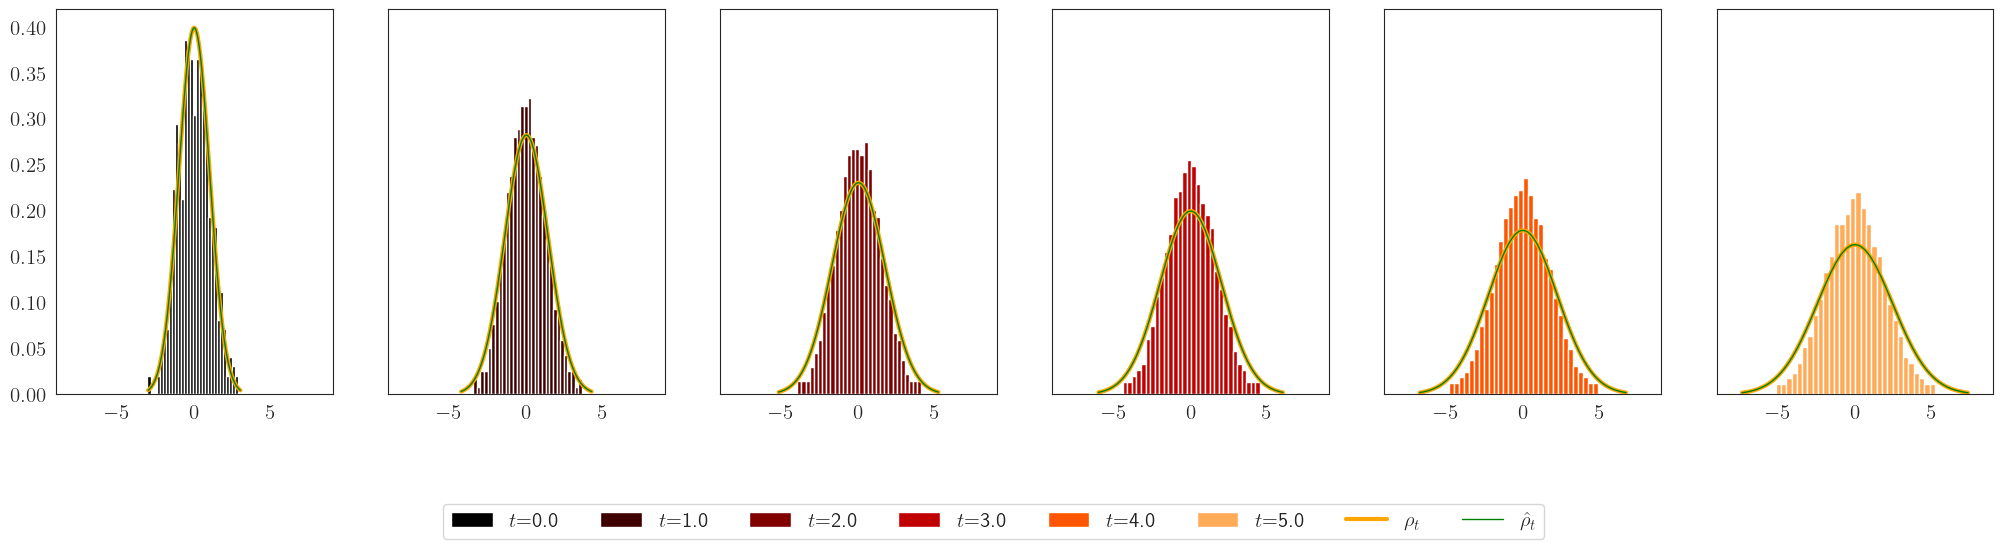

In [120]:
sns.styletype='white'
cmap = plt.get_cmap("gist_heat")
fig, axs = plt.subplots(1, 6, figsize=(25,5), sharey=True)
plot_steps = [0, 100, 200, 300, 400, 500]

for i in range(len(plot_steps)):
    step = plot_steps[i]
    time = step*step_size
    xlim = 9
    color = cmap((i)/len(plot_steps))

    axs[i].hist(X_SB[plot_steps[i]//10 ,:], color=color, edgecolor='white', bins=30, density=True, label=f'$t$={time}')
    true_var = sigma_squared + time
    SB_var = forward_SB_var(sigma_squared, step_size, k=step)
    print(f'Step: {step}, idx: {plot_steps[i]//10}, true var: {true_var}, SB_var: {SB_var}')
    x, pdf_values = draw_gaussian(mean=0, std_dev=np.sqrt(true_var))
    if i == len(plot_steps)-1:
        axs[i].plot(x, pdf_values, label=r'$\rho_t$', color='orange', linewidth=3)
    else:
        axs[i].plot(x, pdf_values, color='orange', linewidth=3)

    x, pdf_values = draw_gaussian(mean=0, std_dev=np.sqrt(SB_var))
    if i == len(plot_steps)-1:
        axs[i].plot(x, pdf_values, label=r'$\hat \rho_t$', color='green', linewidth=1)
    else:
        axs[i].plot(x, pdf_values, color='green', linewidth=1)

        
    axs[i].set_xlim(-xlim, xlim)
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(plot_steps)+2)
plt.show()

Now we make the animation of all the steps.

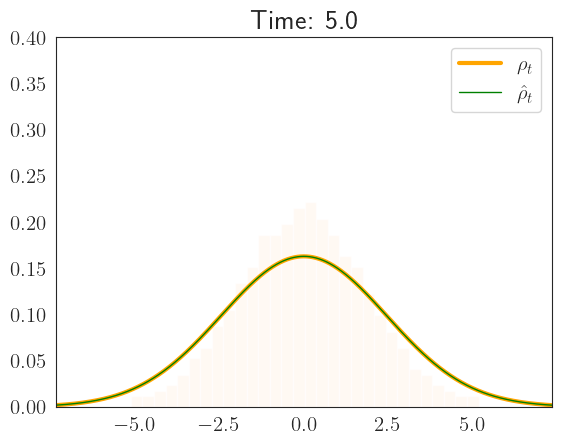

In [129]:
num_frames = len(all_steps)

# Create a figure
fig, ax = plt.subplots()

# Create the animation

animation = FuncAnimation(fig, update_plot, frames=num_frames, fargs=(X_SB, all_steps, step_size, sigma_squared, True, 3*np.sqrt(sigma_squared + total_time), 0.4), interval=10)
animation.save(os.path.join(dir, f'eps{step_size}_time{total_time}.gif'), writer='imagemagick', fps=2)

# Show the animation
plt.show()


#### Sinkhorn, $\epsilon = 0.1$

In [132]:
step_size = 0.1
max_steps = int(total_time/step_size)
all_steps = 10*np.arange(1, (max_steps//10)+1)
dir = f'{SB_estimation_method}/{source_dist}/{direction}'
file_path = os.path.join(dir, f'eps{step_size}_time{total_time}.npy')
X_SB = np.load(file_path)
X_SB.shape

(6, 500)

Step: 0, idx: 0, true var: 1.0, SB_var: 1
Step: 10, idx: 1, true var: 2.0, SB_var: 1.9993394637211244
Step: 20, idx: 2, true var: 3.0, SB_var: 2.999124466238449
Step: 30, idx: 3, true var: 4.0, SB_var: 3.9990179584482197
Step: 40, idx: 4, true var: 5.0, SB_var: 4.99895437290321
Step: 50, idx: 5, true var: 6.0, SB_var: 5.998912115935248


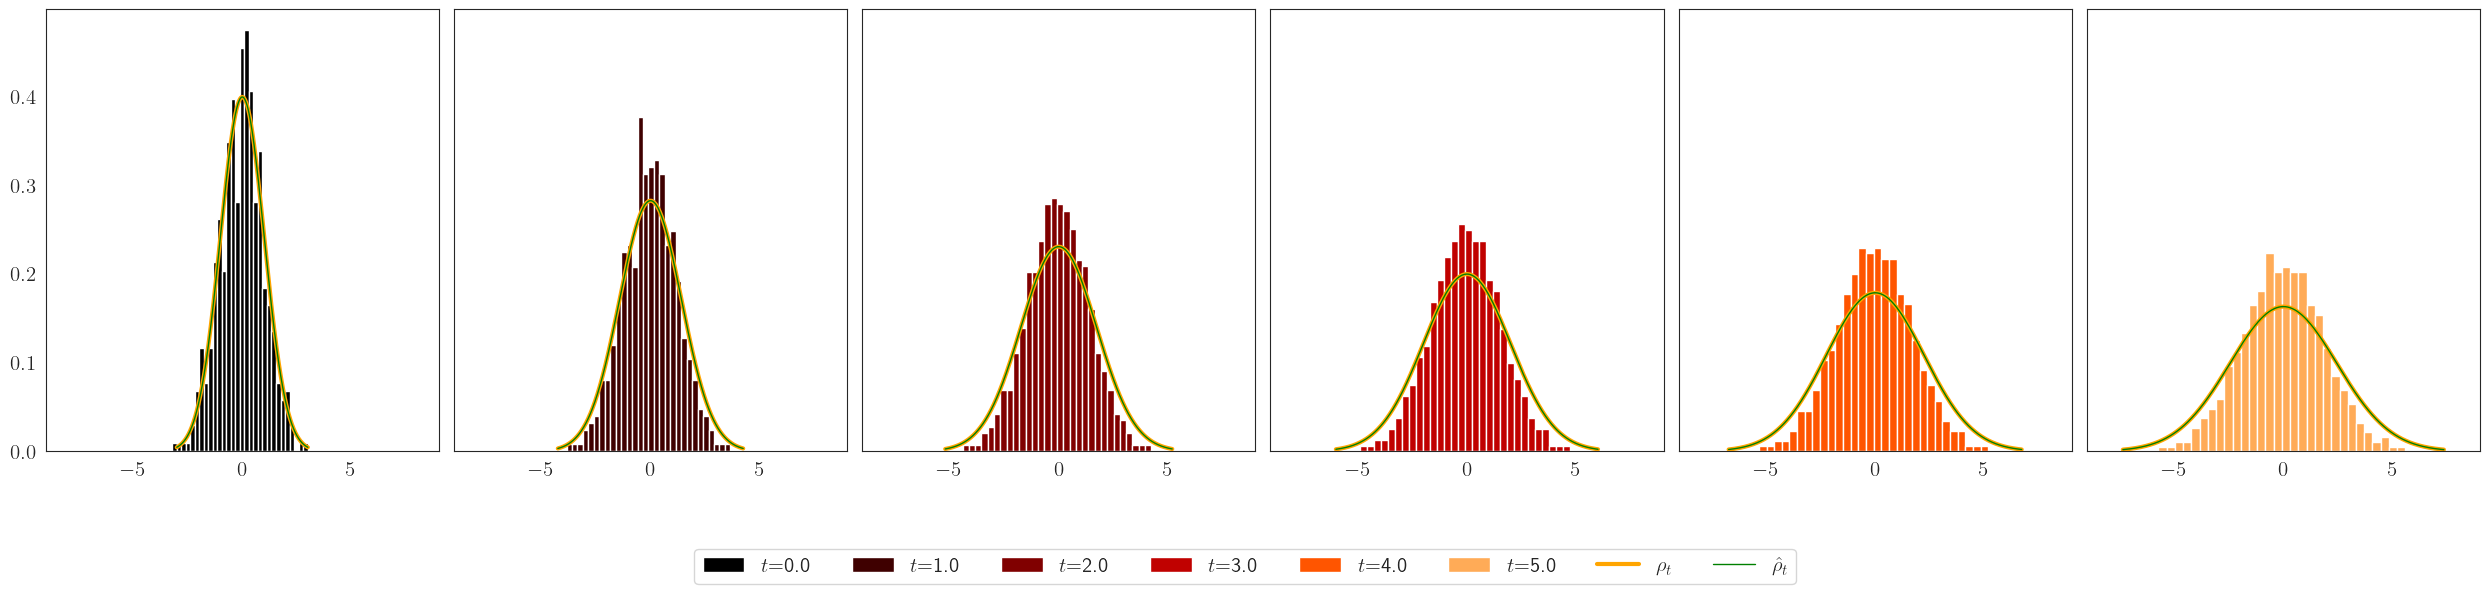

In [133]:
sns.styletype='white'
cmap = plt.get_cmap("gist_heat")
fig, axs = plt.subplots(1, 6, figsize=(25,5), sharey=True)
plot_steps = [0, 10, 20, 30, 40, 50]

for i in range(len(plot_steps)):
    step = plot_steps[i]
    time = step*step_size
    xlim = 9
    color = cmap(i/len(plot_steps))

    axs[i].hist(X_SB[plot_steps[i]//10 ,:], color=color, edgecolor='white', bins=30, density=True, label=f'$t$={time}')
    true_var = sigma_squared + time
    SB_var = forward_SB_var(sigma_squared, step_size, k=step)
    print(f'Step: {step}, idx: {plot_steps[i]//10}, true var: {true_var}, SB_var: {SB_var}')
    x, pdf_values = draw_gaussian(mean=0, std_dev=np.sqrt(true_var))
    if i == len(plot_steps)-1:
        axs[i].plot(x, pdf_values, label=r'$\rho_t$', color='orange', linewidth=3)
    else:
        axs[i].plot(x, pdf_values, color='orange', linewidth=3)

    x, pdf_values = draw_gaussian(mean=0, std_dev=np.sqrt(SB_var))
    if i == len(plot_steps)-1:
        axs[i].plot(x, pdf_values, label=r'$\hat \rho_t$', color='green', linewidth=1)
    else:
        axs[i].plot(x, pdf_values, color='green', linewidth=1)

        
    axs[i].set_xlim(-xlim, xlim)
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(plot_steps)+2)
plt.tight_layout()
plt.show()

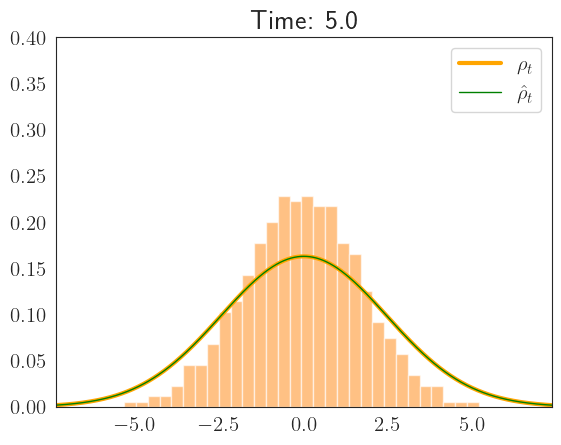

In [134]:
num_frames = len(all_steps)

# Create a figure
fig, ax = plt.subplots()

# Create the animation

animation = FuncAnimation(fig, update_plot, frames=num_frames, fargs=(X_SB, all_steps, step_size, sigma_squared, True, 3*np.sqrt(sigma_squared + total_time), 0.4), interval=10)
animation.save(os.path.join(dir, f'eps{step_size}_time{total_time}.gif'), writer='imagemagick', fps=2)

# Show the animation
plt.show()


#### MCMC, $\epsilon = 0.1$

In [135]:
SB_estimation_method = 'mcmc'
source_dist = 'gaussian'
direction = 'forward'
total_time = 5
mean, sigma, sigma_squared = 0, 1, 1

In [136]:
step_size = 0.1
max_steps = int(total_time/step_size)
all_steps = 10*np.arange(1, (max_steps//10)+1)
dir = f'{SB_estimation_method}/{source_dist}/{direction}'
file_path = os.path.join(dir, f'eps{step_size}_time{total_time}.npy')
X_SB = np.load(file_path)
X_SB.shape

(5, 500)

Step: 10, idx: 0, true var: 2.0, SB_var: 1.9993394637211244
Step: 20, idx: 1, true var: 3.0, SB_var: 2.999124466238449
Step: 30, idx: 2, true var: 4.0, SB_var: 3.9990179584482197
Step: 40, idx: 3, true var: 5.0, SB_var: 4.99895437290321
Step: 50, idx: 4, true var: 6.0, SB_var: 5.998912115935248


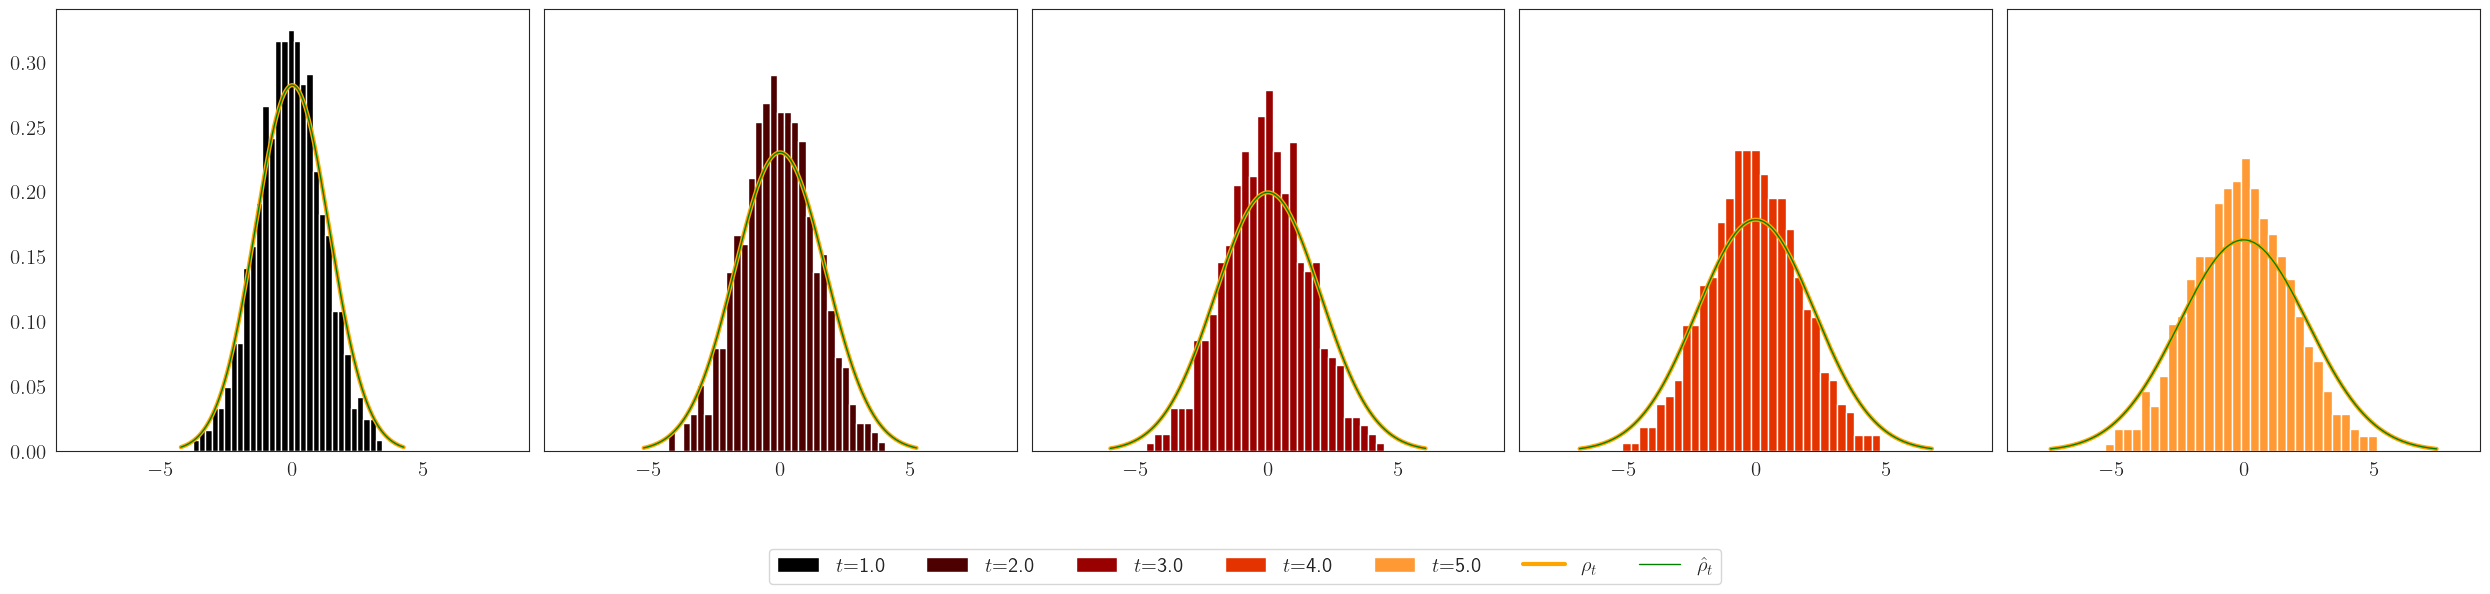

In [138]:
sns.styletype='white'
cmap = plt.get_cmap("gist_heat")
fig, axs = plt.subplots(1, 5, figsize=(25,5), sharey=True)
plot_steps = np.array(np.arange(1, total_time+1)/step_size, dtype=int)

for i in range(len(plot_steps)):
    step = plot_steps[i]
    time = step*step_size
    xlim = 9
    color = cmap(i/len(plot_steps))

    axs[i].hist(X_SB[plot_steps[i]//10-1 ,:], color=color, edgecolor='white', bins=30, density=True, label=f'$t$={time}')
    true_var = sigma_squared + time
    SB_var = forward_SB_var(sigma_squared, step_size, k=step)
    print(f'Step: {step}, idx: {plot_steps[i]//10-1}, true var: {true_var}, SB_var: {SB_var}')
    x, pdf_values = draw_gaussian(mean=0, std_dev=np.sqrt(true_var))
    if i == len(plot_steps)-1:
        axs[i].plot(x, pdf_values, label=r'$\rho_t$', color='orange', linewidth=3)
    else:
        axs[i].plot(x, pdf_values, color='orange', linewidth=3)

    x, pdf_values = draw_gaussian(mean=0, std_dev=np.sqrt(SB_var))
    if i == len(plot_steps)-1:
        axs[i].plot(x, pdf_values, label=r'$\hat \rho_t$', color='green', linewidth=1)
    else:
        axs[i].plot(x, pdf_values, color='green', linewidth=1)

        
    axs[i].set_xlim(-xlim, xlim)
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(plot_steps)+2)
plt.tight_layout()
plt.show()

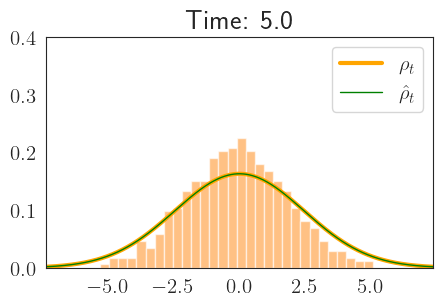

In [140]:
num_frames = len(all_steps)

# Create a figure
fig, ax = plt.subplots(figsize = (5,3))

# Create the animation

animation = FuncAnimation(fig, update_plot, frames=num_frames, fargs=(X_SB, all_steps, step_size, sigma_squared, True, 3*np.sqrt(sigma_squared + total_time), 0.4), interval=10)
animation.save(os.path.join(dir, f'eps{step_size}_time{total_time}.gif'), writer='imagemagick', fps=2)

# Show the animation
plt.show()


### Example 2: Starting with a mixture of Gaussian distributions

#### Sinkhorn, $\epsilon = 0.1$

[]

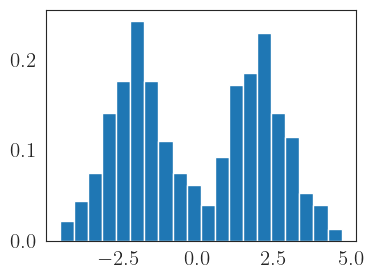

In [145]:
mu1, mu2 = -2, 2
X = np.concatenate((np.random.normal(mu1, 1, 500//2), np.random.normal(mu2, 1, 500//2)))
fig = plt.figure(figsize= (4,3))
plt.hist(X, density = True, bins=20)
plt.plot()

In [146]:
SB_estimation_method = 'sinkhorn'
source_dist = 'gaussian_mix'
direction = 'forward'
total_time = 5
mu1, mu2 = -2, 2

In [147]:
step_size = 0.1
max_steps = int(total_time/step_size)
all_steps = 10*np.arange(1, (max_steps//10)+1)
plot_steps = np.array(np.arange(6)/step_size, dtype=int)
print(plot_steps)
dir = f'{SB_estimation_method}/{source_dist}/{direction}'
file_path = os.path.join(dir, f'eps{step_size}_time{total_time}.npy')
X_SB = np.load(file_path)
X_SB.shape

[ 0 10 20 30 40 50]


(6, 500)

Step: 0, idx: 0, true var: 1.0, SB_var: 1
Step: 10, idx: 1, true var: 2.0, SB_var: 1.9993394637211244
Step: 20, idx: 2, true var: 3.0, SB_var: 2.999124466238449
Step: 30, idx: 3, true var: 4.0, SB_var: 3.9990179584482197
Step: 40, idx: 4, true var: 5.0, SB_var: 4.99895437290321
Step: 50, idx: 5, true var: 6.0, SB_var: 5.998912115935248


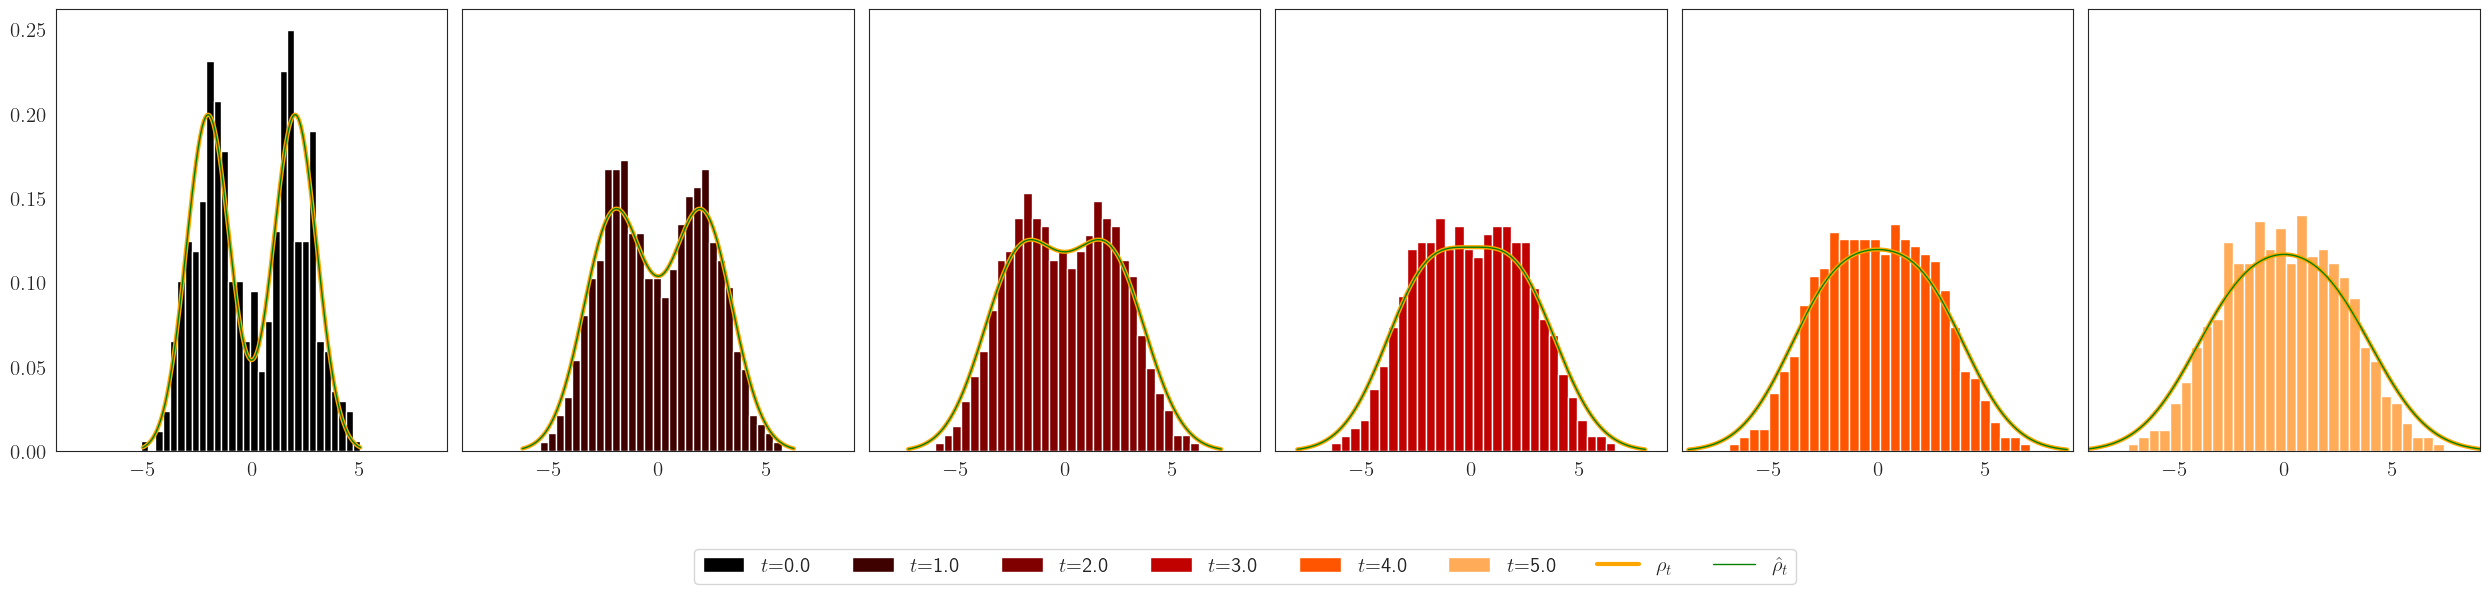

In [143]:
sns.styletype='white'
cmap = plt.get_cmap("gist_heat")
fig, axs = plt.subplots(1, 6, figsize=(25,5), sharey=True)

for i in range(len(plot_steps)):
    step = plot_steps[i]
    time = step*step_size
    xlim = 9
    color = cmap(i/len(plot_steps))

    axs[i].hist(X_SB[plot_steps[i]//10 ,:], color=color, edgecolor='white', bins=30, density=True, label=f'$t$={time}')

    true_var = sigma_squared + time
    SB_var = forward_SB_var(sigma_squared, step_size, k=step)
    print(f'Step: {step}, idx: {plot_steps[i]//10}, true var: {true_var}, SB_var: {SB_var}')
    x, pdf_values = draw_gaussian_mix(mu1=mu1, mu2=mu2, std_dev=np.sqrt(true_var))
    if i == len(plot_steps)-1:
        axs[i].plot(x, pdf_values, label=r'$\rho_t$', color='orange', linewidth=3)
    else:
        axs[i].plot(x, pdf_values, color='orange', linewidth=3)

    x, pdf_values = draw_gaussian_mix(mu1=mu1, mu2=mu2, std_dev=np.sqrt(SB_var))
    if i == len(plot_steps)-1:
        axs[i].plot(x, pdf_values, label=r'$\hat \rho_t$', color='green', linewidth=1)
    else:
        axs[i].plot(x, pdf_values, color='green', linewidth=1)

        
    axs[i].set_xlim(-xlim, xlim)
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(plot_steps)+2)
plt.tight_layout()
plt.show()

MovieWriter stderr:
convert-im6.q16: unexpected end-of-file `-': No such file or directory @ error/rgb.c/ReadRGBImage/244.
convert-im6.q16: no images defined `sinkhorn/gaussian_mix/forward/eps0.1_time5.gif' @ error/convert.c/ConvertImageCommand/3229.



CalledProcessError: Command '['convert', '-size', '500x300', '-depth', '8', '-delay', '50.0', '-loop', '0', 'rgba:-', '-layers', 'OptimizePlus', 'sinkhorn/gaussian_mix/forward/eps0.1_time5.gif']' returned non-zero exit status 1.

Error in callback <function _draw_all_if_interactive at 0x7f98a5e00940> (for post_execute):


TypeError: draw_gaussian() got multiple values for argument 'std_dev'

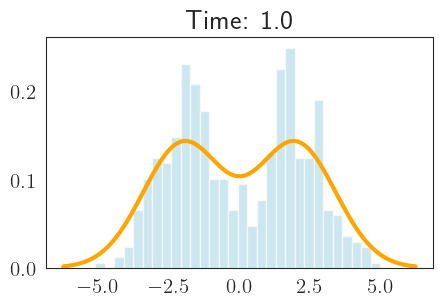

In [148]:
num_frames = len(all_steps)

# Create a figure
fig, ax = plt.subplots(figsize = (5,3))

# Create the animation
animation = FuncAnimation(fig, update_plot_gauss_mix, frames=num_frames, fargs=(X_SB, all_steps, step_size, mu1, mu2, sigma_squared, True, 3*np.sqrt(sigma_squared + total_time), 0.25), interval=10)
animation.save(os.path.join(dir, f'eps{step_size}_time{total_time}.gif'), writer='imagemagick', fps=2)

# Show the animation
plt.show()


#### MCMC, $\epsilon = 0.1$

In [112]:
SB_estimation_method = 'mcmc'
source_dist = 'gaussian_mix'
direction = 'forward'
total_time = 5
mu1, mu2 = -2, 2

In [114]:
step_size = 0.1
max_steps = int(total_time/step_size)
plot_steps = np.array(np.arange(1, 6)/step_size, dtype=int)
print(plot_steps)
dir = f'{SB_estimation_method}/{source_dist}/{direction}'
file_path = os.path.join(dir, f'eps{step_size}_time{total_time}.npy')
X_SB = np.load(file_path)
X_SB.shape

[10 20 30 40 50]


(5, 500)

Step: 10, idx: 0, true var: 2.0, SB_var: 1.9993394637211244
Step: 20, idx: 1, true var: 3.0, SB_var: 2.999124466238449
Step: 30, idx: 2, true var: 4.0, SB_var: 3.9990179584482197
Step: 40, idx: 3, true var: 5.0, SB_var: 4.99895437290321
Step: 50, idx: 4, true var: 6.0, SB_var: 5.998912115935248


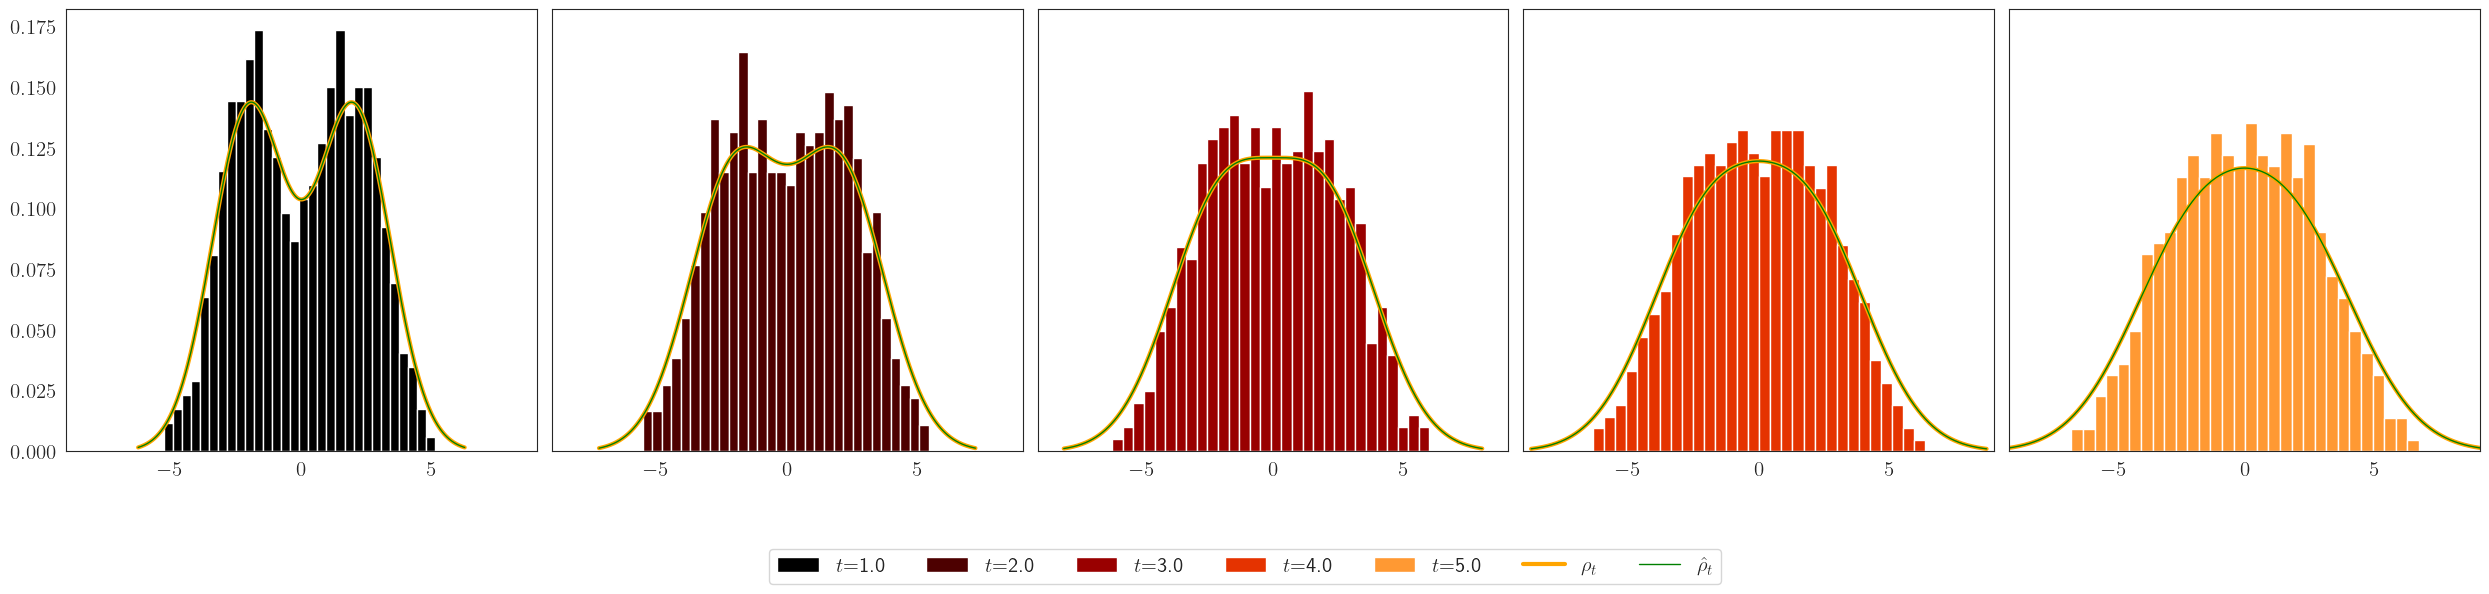

In [116]:
sns.styletype='white'
cmap = plt.get_cmap("gist_heat")
fig, axs = plt.subplots(1, 5, figsize=(25,5), sharey=True)

for i in range(len(plot_steps)):
    step = plot_steps[i]
    time = step*step_size
    xlim = 9
    color = cmap(i/len(plot_steps))

    axs[i].hist(X_SB[plot_steps[i]//10 - 1,:], color=color, edgecolor='white', bins=30, density=True, label=f'$t$={time}')

    true_var = sigma_squared + time
    SB_var = forward_SB_var(sigma_squared, step_size, k=step)
    print(f'Step: {step}, idx: {plot_steps[i]//10 - 1}, true var: {true_var}, SB_var: {SB_var}')
    x, pdf_values = draw_gaussian_mix(mu1=mu1, mu2=mu2, std_dev=np.sqrt(true_var))
    if i == len(plot_steps)-1:
        axs[i].plot(x, pdf_values, label=r'$\rho_t$', color='orange', linewidth=3)
    else:
        axs[i].plot(x, pdf_values, color='orange', linewidth=3)

    x, pdf_values = draw_gaussian_mix(mu1=mu1, mu2=mu2, std_dev=np.sqrt(SB_var))
    if i == len(plot_steps)-1:
        axs[i].plot(x, pdf_values, label=r'$\hat \rho_t$', color='green', linewidth=1)
    else:
        axs[i].plot(x, pdf_values, color='green', linewidth=1)

        
    axs[i].set_xlim(-xlim, xlim)
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(plot_steps)+2)
plt.tight_layout()
plt.show()

In [ ]:
# Thin

methods = ['mcmc', 'sinkhorn']
for method in methods:
    SB_estimation_method = method
    source_dist = 'gaussian'
    direction = 'forward'
    step_size = 0.01
    dir = f'{SB_estimation_method}/{source_dist}/{direction}'

    if source_dist == 'thin_gaussian':
        mu, sigma_squared, sigma = 0, 0.25, 0.5
        time = 2

    elif source_dist == 'gaussian':
        mu, sigma_squared, sigma = 0, 4, 2
        time = 3
    elif source_dist == 'gaussian_mix':
        means, sigma_squared, sigma = [-2, 2], 4, 2
        time = 3
    else:
        ValueError


    max_steps = int(time/step_size)
    steps = 10*np.arange(1, (max_steps//10)+1)

    # Set the number of frames
    num_frames = len(steps)


    file_path = os.path.join(dir, f'eps{step_size}.npy')
    X_SB = np.load(file_path)
    hist, bin_edges = np.histogram(X_SB[0,:], bins=30, density=True)
    ylim = np.max(hist)
    print(X_SB.shape)

    # Create a figure
    fig, ax = plt.subplots()

    # Create the animation

    if source_dist == 'gaussian_mix':
        animation = FuncAnimation(fig, update_plot_gauss_mix, frames=num_frames, fargs=((X_SB, steps, step_size, means, sigma_squared, True, means[1]+3*np.sqrt(sigma_squared + time), 0.2)), interval=10)
    else:
        animation = FuncAnimation(fig, update_plot, frames=num_frames, fargs=(X_SB, steps, step_size, sigma_squared, True, 3*np.sqrt(sigma_squared + time), 0.2), interval=10)
    animation.save(os.path.join(dir, f'eps{step_size}.gif'), writer='imagemagick', fps=2)

    # Show the animation
    plt.show()
